
# Agenda

### A- Introduction to QC and CUDA-Q platform

- Installation of CUDA-Q

### B- Quantum Circuit Basics

B.1- Qubit allocation

B.2- Quantum gates

B.3- Quantum kernel

B.4- Backends & running CUDA-Q programs

B.5- Examples

### C- Quantum algorithmic primitives

C.1- cudaq.sample()

- Mid-circuit measurement & conditional sampling

C.2- cudaq.observe()

- Spin Hamiltonian operator

### D- Parameterized Circuit

### E- Variational Quantum Algorithm

### F- Multi-QPUs and Multi-GPUs

### G- Advanced Examples

![img](./frame.png)

### A- Introduction to QC and CUDA-Q platform

- #### Some basics: to review basics of quantum computing and the linear algebra needed for this tutorial, see (QC-intro.pdf)

- #### CUDA-Q stack

![img](./CUDA-Q.png)

- Single-source Python and C++ programming model
- High performance compiler for hybrid GPU/CPU/QPU systems
- QPU agnostic - works with any type of QPU, emulated or physical
- Supports both state-vector and tensor network backend: backends are optimized for NVIDIA GPUs, including multi-GPU, multi-node support for HPC.

#### CUDA-Q performance
- NVIDIA CUDA-Q can significantly speed up quantum algorithms, compared to other quantum frameworks. Quantum algorithms can achieve a speedup of up to 2500X over CPU, scaling number of qubits using multiple GPUs.

![img](./QML-perfo.png)

#### Installation of CUDA-Q: visit [CUDA-Q installation](https://nvidia.github.io/cuda-quantum/latest/using/install/install.html)

To explore more, visit this [web page](https://developer.nvidia.com/cuda-q), [GitHub](https://github.com/NVIDIA/cuda-quantum), [documentation](https://nvidia.github.io/cuda-quantum/latest/#)

### B- Quantum circuit basics

![img](./basic-circuit.png)


### B.1- Qubit allocation

- cudaq.qubit(): a single quantum bit (2-level) in the discrete quantum memory space. 

```qubit=cudaq.qubit()```

- cudaq.qvector(N): a multi quantum bit ($2^N$ level) in the discrete quantum memory

```qubits=cudaq.qvector(N)```

    
- Is initialized to the |0> computational basis state.

- Owns the quantum memory, therefore it cannot be copied or moved (no-cloning theorem). It can be passed by reference (i.e., references to qubit vectors).


### B.2- Quantum gates


- x: Not gate (Pauli-X gate)

```python
q=cudaq.qubit()
x(q)
```
- h: Hadamard gate

```python
q=cudaq.qvector(2)
h(q[0])
```

- x.ctrl(control,target) or ([control_1, control_2], target): C-NOT gate

```python
q=cudaq.qvector(3)
x.ctrl(q[0],q[1])
```

- rx(angle, qubit): rotation around x-axis
```python
q=cudaq.qubit()
rx(np.pi,q)
```

- adj: adjoint transformation
```python
q=cudaq.qubit()
rx(np.pi,q)
rx.adj(np.pi,q)
```

- mz: measure qubits in the computational basis

```python
q=cudaq.qvector(2)
h(q[0])
x.ctrl(q[0],q[1])
mz(q)
```


To learn more about the quantum operations available in CUDA-Q, visit [this page](https://nvidia.github.io/cuda-quantum/latest/specification/cudaq/kernels.html)

### B.3- Quantum kernel

- To differentiate between host and quantum device code, the CUDA-Q programming model defines the concept of a quantum kernel.

- All quantum kernels must be annotated to indicate they are to be compiled for, and executed on, a specified quantum coprocessor. 

- Other language bindings may opt to use other language features to enable function annotation or decoration (e.g. a `@cudaq.kernel()` function decorator in Python and `__qpu__` in C++).

- Quantum kernel can take classical data as input


``` python
@cudaq.kernel()
def my_first_entry_point_kernel(x : float):
   ... quantum code ... 

@cudaq.kernel()
def my_second_entry_point_kernel(x : float, params : list[float]):
   ... quantum code ... 

```

- CUDA-Q kernels can serve as input to other quantum kernels and invoked by kernel function body code.


```python
@cudaq.kernel()
def MyStatePrep(qubits : cudaq.qview):
    ... apply state prep operations on qubits ... 

@cudaq.kernel()
def MyGenericAlgorithm(statePrep : typing.Callable[[cudaq.qview], None]):
    q = cudaq.qvector(10)
    statePrep(q)
    ...

MyGenericAlgorithm(MyStatePrep)
```

- ```cudaq.qview()```: a non-owning reference to a subset of the discrete quantum memory space. It does not own its elements and can therefore be passed by value or reference. (see [this page](https://nvidia.github.io/cuda-quantum/latest/specification/cudaq/types.html#quantum-containers))

- Vectors inside the quantum kernel can be only constructed with specified size

```python
@cudaq.kernel
def kernel(N : int):

   # Not Allowed
   # i = []
   # i.append(1)

   # Allowed
   i = [0 for k in range(5)]
   j = [0 for _ in range(N)]
   i[2] = 3
   f = [1., 2., 3.]
   k = 0
   pi = 3.1415926

```

- To learn more about the CUDA-Q quantum kernel, visit [this page](https://github.com/NVIDIA/cuda-quantum/blob/main/docs/sphinx/specification/cudaq/kernels.rst)

### B.4- Backends & running CUDA-Q programs

Two options:

1. Define the target when running the program:
``` python3 program.py [...] --target <target_name>```

2. Target can be defined in the application code:
```cudaq.set_target('target_name')``` . Then, to run the program, drop the target flag: 
```python3 program.py [...]```

What is target_name?

1. State vector simulators:
    - Single-GPU (Default If an NVIDIA GPU and CUDA runtime libraries are available): ```python3 program.py [...] --target nvidia``` 
    - Multi-GPUs: ```mpirun -np 2 python3 program.py [...] --target nvidia-mgpu``` 
2. Tensor network simulator:
    - Single-GPU: ```python3 program.py [...] --target tensornet``` 
    - Multi-GPUs: ```mpirun -np 2 python3 program.py [...] --target tensornet``` 
3. Matrix Product state:
    - Only supports single-GPU simulation: ```python3 program.py [...] --target tensornet-mps``` 
4. NVIDIA Quantum Cloud
    - Run any of the above backends using NVIDIA-provided cloud GPUs (early access only). To learn more, visit [this page](https://www.nvidia.com/en-us/solutions/quantum-computing/cloud/).
    - E.g. `cudaq.set_target('nvqc', backend='tensornet')`
5. Quantum hardware backend (to learn more, visit [this page](https://nvidia.github.io/cuda-quantum/latest/using/backends/hardware.html)):
    - ```cudaq.set_target('QPU_name')```. QPU_name could be `ionq`, `quantinuum`, `iqm`, `oqc`, ...etc.


To learn more about CUDA-Q backends, visit [this page](https://nvidia.github.io/cuda-quantum/latest/using/backends/backends.html)

### B.5- Examples

In [93]:
# Single qubit example

import cudaq

# Set the backend target
cudaq.set_target('nvidia')

# We begin by defining the `Kernel` that we will construct our
# program with.
@cudaq.kernel()
def first_kernel():
    '''
    This is our first CUDA-Q kernel.
    '''
    # Next, we can allocate a single qubit to the kernel via `qubit()`.
    qubit = cudaq.qubit()

    # Now we can begin adding instructions to apply to this qubit!
    # Here we'll just add non-parameterized
    # single qubit gate that is supported by CUDA-Q.
    h(qubit)
    x(qubit)
    y(qubit)
    z(qubit)
    t(qubit)
    s(qubit)

    # Next, we add a measurement to the kernel so that we can sample
    # the measurement results on our simulator!
    mz(qubit)

print(cudaq.draw(first_kernel))


     ╭───╮╭───╮╭───╮╭───╮╭───╮╭───╮
q0 : ┤ h ├┤ x ├┤ y ├┤ z ├┤ t ├┤ s ├
     ╰───╯╰───╯╰───╯╰───╯╰───╯╰───╯



In [94]:
# Multi-qubit example

import cudaq

cudaq.set_target('nvidia')

@cudaq.kernel
def second_kernel(N:int):
    qubits=cudaq.qvector(N)

    h(qubits[0])
    x.ctrl(qubits[0],qubits[1])
    x.ctrl(qubits[0],qubits[2])
    x(qubits)

    mz(qubits)

print(cudaq.draw(second_kernel,3))

     ╭───╮          ╭───╮
q0 : ┤ h ├──●────●──┤ x ├
     ╰───╯╭─┴─╮  │  ├───┤
q1 : ─────┤ x ├──┼──┤ x ├
          ╰───╯╭─┴─╮├───┤
q2 : ──────────┤ x ├┤ x ├
               ╰───╯╰───╯



In [95]:
import cudaq

cudaq.set_target('nvidia')

@cudaq.kernel
def bar(N:int):
    qubits=cudaq.qvector(N)
    # front and back: return a direct refernce 
    controls = qubits.front(N - 1)
    target = qubits.back()
    x.ctrl(controls, target)


print(cudaq.draw(bar,3))

          
q0 : ──●──
       │  
q1 : ──●──
     ╭─┴─╮
q2 : ┤ x ├
     ╰───╯



### C- Quantum Algorithmic Primitives

### C.1 cudaq.sample():

Sample the state of a given quantum circuit for a specified number of shots (circuit execution)

This function takes as input a quantum kernel instance followed by the concrete arguments at which the kernel should be invoked

In [96]:
import cudaq

cudaq.set_target('nvidia')

@cudaq.kernel
def bell(N:int):
    qubits=cudaq.qvector(N)

    h(qubits[0])
    x.ctrl(qubits[0], qubits[1])

    mz(qubits)

print(cudaq.draw(bell,2))
# Sample the state generated by bell
# shots_count: the number of kernel executions. Default is 1000
counts = cudaq.sample(bell, 2, shots_count=10000) 

# Print to standard out
print(counts)

# Fine-grained access to the bits and counts 
for bits, count in counts.items():
    print('Observed: {}, {}'.format(bits, count))


     ╭───╮     
q0 : ┤ h ├──●──
     ╰───╯╭─┴─╮
q1 : ─────┤ x ├
          ╰───╯

{ 00:4916 11:5084 }

Observed: 00, 4916
Observed: 11, 5084


In [97]:
import cudaq

cudaq.set_target('nvidia')

@cudaq.kernel
def third_example(N:int, theta:list[float]):
    qubit=cudaq.qvector(N)

    h(qubit)

    for i in range(0,N//2):
        ry(theta[i],qubit[i])
    

    x.ctrl([qubit[0],qubit[1]],qubit[2]) #ccx
    x.ctrl([qubit[0],qubit[1],qubit[2]],qubit[3]) #cccx
    x.ctrl(qubit[0:3],qubit[3]) #cccx using Python slicing syntax

    mz(qubit)

params=[0.15,1.5]

print(cudaq.draw(third_example, 4, params))

result=cudaq.sample(third_example, 4, params, shots_count=5000)

print('Result: ', result)

print('Most probable bit string: ', result.most_probable())   

     ╭───╮╭──────────╮               
q0 : ┤ h ├┤ ry(0.15) ├──●────●────●──
     ├───┤├─────────┬╯  │    │    │  
q1 : ┤ h ├┤ ry(1.5) ├───●────●────●──
     ├───┤╰─────────╯ ╭─┴─╮  │    │  
q2 : ┤ h ├────────────┤ x ├──●────●──
     ├───┤            ╰───╯╭─┴─╮╭─┴─╮
q3 : ┤ h ├─────────────────┤ x ├┤ x ├
     ╰───╯                 ╰───╯╰───╯

Result:  { 1000:1 1101:677 0100:523 1011:1 1100:706 0110:530 1111:717 1110:705 1001:1 0101:564 0111:575 }

Most probable bit string:  1111


###  Mid-circuit measurement & conditional sampling

In [98]:
import cudaq

cudaq.set_target('nvidia')

@cudaq.kernel
def mid_circuit_m(theta:float):
    qubit=cudaq.qvector(2)
    ancilla=cudaq.qubit()

    ry(theta,ancilla)

    aux=mz(ancilla)
    if aux:
        x(qubit[0])
        x(ancilla)
    else:
        x(qubit[0])
        x(qubit[1])
    
    mz(ancilla)
    mz(qubit)

angle=0.5
result=cudaq.sample(mid_circuit_m, angle)
print(result)

{ 
  __global__ : { 100:66 110:934 }
   aux : { 1:66 0:934 }
}



- Here, we see that we have measured the ancilla qubit to a register named ```aux```

- If any measurements appear in the kernel, then only the measured qubits will appear in the ```__global__``` register, and they will be sorted in qubit allocation order.

- To learn more about cudaq.sample(), visit [this page](https://nvidia.github.io/cuda-quantum/latest/specification/cudaq/algorithmic_primitives.html#cudaq-sample)

### C.2 cudaq.observe()

- A common task in variational algorithms is the computation of the expected value of a given observable with respect to a parameterized quantum circuit (⟨H⟩(𝚹) = ⟨ψ(𝚹)|H|ψ(𝚹)⟩).

- The `cudaq.observe()` function is provided to enable one to quickly compute this expectation value via execution of the parameterized quantum circuit

- In the example below, the obervable H is $H= 5.907 \, I - 2.1433 \, X_0X_1 -2.1433\, Y_0 Y_1 + 0.21829 \, Z_0 -6.125\, Z_1$

In [99]:
# The example here shows a simple use case for the `cudaq.observe``
# function in computing expected values of provided spin hamiltonian operators.

import cudaq
from cudaq import spin

cudaq.set_target('nvidia')

qubit_num=2

@cudaq.kernel
def init_state(qubits:cudaq.qview):
    n=qubits.size()
    for i in range(n):
        x(qubits[i])

@cudaq.kernel
def observe_example(theta: float):
    qvector = cudaq.qvector(qubit_num)

    init_state(qvector)
    ry(theta, qvector[1])
    x.ctrl(qvector[1], qvector[0])


spin_operator = 5.907 - 2.1433 * spin.x(0) * spin.x(1) - 2.1433 * spin.y(
    0) * spin.y(1) + .21829 * spin.z(0) - 6.125 * spin.z(1)

# Pre-computed angle that minimizes the energy expectation of the `spin_operator`.
angle = 0.59

energy = cudaq.observe(observe_example, spin_operator, angle).expectation()
print(f"Energy is {energy}")


Energy is 13.562794135947076


### Spin Hamiltonian operator

CUDA-Q defines convenience functions in `cudaq.spin` namespace that produce the primitive X, Y, and Z Pauli operators on specified qubit indices which can subsequently be used in algebraic expressions to build up more complicated Pauli tensor products and their sums.

$H= 5.907 \, I - 2.1433 \, X_0X_1 -2.1433\, Y_0 Y_1 + 0.21829 \, Z_0 -6.125\, Z_1$

```python
spin_operator = 5.907 - 2.1433 * spin.x(0) * spin.x(1) - 2.1433 * spin.y(
    0) * spin.y(1) + .21829 * spin.z(0) - 6.125 * spin.z(1)
```

In [100]:
from cudaq import spin

hamiltonian = 0.5*spin.z(0) + spin.x(1) + spin.y(0) + spin.y(0) * spin.y(1)+ spin.x(0)*spin.y(1)*spin.z(2)

# add some more terms
for i in range(2):
  hamiltonian += -2.0*spin.z(i)*spin.z(i+1)

print(hamiltonian)

print('Total number of terms in the spin hamiltonian: ',hamiltonian.get_term_count())


[-2+0j] IZZ
[-2+0j] ZZI
[1+0j] XYZ
[0.5+0j] ZII
[1+0j] YII
[1+0j] IXI
[1+0j] YYI

Total number of terms in the spin hamiltonian:  7


### D- Parameterized Circuit

In [101]:
import cudaq
from cudaq import spin

cudaq.set_target("nvidia")

@cudaq.kernel
def param_circuit(theta: list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
parameters = [0.0, 0.0]

print(cudaq.draw(param_circuit,parameters))

# Compute the expectation value using the initial parameters.
expectation_value = cudaq.observe(param_circuit, hamiltonian,parameters).expectation()

print('Expectation value of the Hamiltonian: ', expectation_value)



     ╭───────╮╭───────╮
q0 : ┤ rx(0) ├┤ ry(0) ├
     ╰───────╯╰───────╯

Expectation value of the Hamiltonian:  1.0


### E- Variational Quantum Algorithm

![img](./VQE.png)

### 1. VQA using ```cudaq.observe()``` & classical optimizer.
- Using cudaq built-in optimizer

In [102]:
import cudaq
from cudaq import spin

cudaq.set_target("nvidia")

@cudaq.kernel
def vqe_circuit(theta: list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
initial_param = [0.0, 0.0]

cost_values = []

def cost(parameters):
    """Returns the expectation value as our cost."""
    expectation_value = cudaq.observe(vqe_circuit, hamiltonian, parameters).expectation()
    cost_values.append(expectation_value)
    return expectation_value

initial_cost_value = cost(initial_param)
print('Initial cost value: ', initial_cost_value)
print('Initial parameters: ', initial_param)

# Define a CUDA-Q optimizer.
optimizer = cudaq.optimizers.COBYLA()
optimizer.initial_parameters = initial_param

result = optimizer.optimize(dimensions=2, function=cost)

print('Final cost value: ', result[0])
print('Optimized parameters: ', result[1])

Initial cost value:  1.0
Initial parameters:  [0.0, 0.0]
Final cost value:  -0.9999999999999981
Optimized parameters:  [3.141592653589793, 0.0]


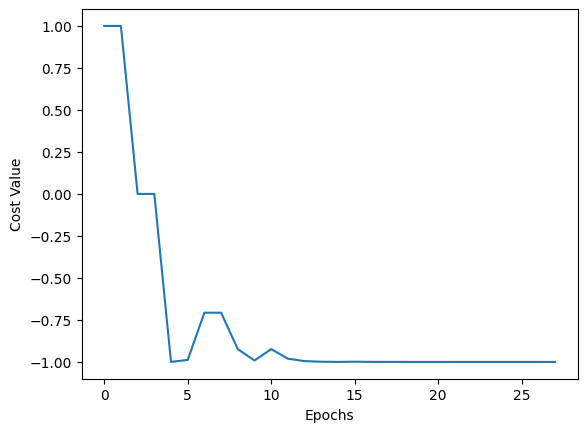

In [103]:
import matplotlib.pyplot as plt

x_values = list(range(len(cost_values)))
y_values = cost_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")
plt.show()

- using third-party optimizer: ex. scipy optimizer

In [104]:
import cudaq
from cudaq import spin
import scipy

cudaq.set_target("nvidia")

@cudaq.kernel
def vqe_circuit_scipy(theta: list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
initial_parameters = [0.0, 0.0]

def cost_scipy(parameters):
    """Returns the expectation value as our cost."""
    expectation_value = cudaq.observe(vqe_circuit_scipy, hamiltonian, parameters).expectation()
    return expectation_value

initial_cost_value = cost_scipy(initial_parameters)
print('Initial cost value: ', initial_cost_value)
print('Initial parameters: ', initial_parameters)


result = scipy.optimize.minimize(cost_scipy,initial_parameters,method='COBYLA')

print('Final cost value: ', result.fun)
print('Optimized parameters: ', result.x)

Initial cost value:  1.0
Initial parameters:  [0.0, 0.0]
Final cost value:  -0.9999999970938906
Optimized parameters:  [3.14159466e+00 1.07798234e-04]


### 2. VQE wrapper: combine ```cudaq.observe()``` and the optimizer

In [105]:
import cudaq
from cudaq import spin

cudaq.set_target("nvidia")

@cudaq.kernel
def vqe_circuit(theta: list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
initial_param = [0.0, 0.0]

optimizer = cudaq.optimizers.COBYLA()
optimizer.max_iterations = 30
optimizer.initial_parameters=initial_param

opt_value, opt_theta = cudaq.vqe(kernel=vqe_circuit, 
                         spin_operator=hamiltonian,
                         optimizer=optimizer,
                         parameter_count=len(initial_param))

print(f"\nminimized <H> = {round(opt_value,16)}")
print(f"optimal theta = {opt_theta}")


minimized <H> = -0.9999999999999981
optimal theta = [3.141592653589793, 0.0]


### F- Multi-QPUs and Multi-GPUs

#### 1. Multi-QPU (nvidia-mqpu)

The `nvidia-mqpu` target is useful for distributing separate quantum circuits to individual GPUs on a single host machine. (For distribution to multiple host machines, see the `remote-mqpu` backend.)

![img](./circuit-mqpu.png)

- To learn more about `nvidia-mqpu` target, visit [this page](https://nvidia.github.io/cuda-quantum/latest/using/backends/platform.html)

In [106]:
import cudaq

cudaq.set_target("nvidia-mqpu")

target = cudaq.get_target()
qpu_count = target.num_qpus()
print("Number of QPUs:", qpu_count)


@cudaq.kernel
def mqpu_example(qubit_count: int):
    qubits = cudaq.qvector(qubit_count)
    # Place qubits in superposition state.
    h(qubits)
    # Measure.
    mz(qubits)

count_futures = []

# We will run on 2 GPUs
print('We run two circuits on 2 QPU and the results are: ')
for qpu in range(2):
    count_futures.append(cudaq.sample_async(mqpu_example, 3, shots_count=2000, qpu_id=qpu))

for counts in count_futures:
    print(counts.get())

Number of QPUs: 5
We run two circuits on 2 QPU and the results are: 
{ 000:282 010:221 111:242 100:256 110:250 001:262 101:242 011:245 }

{ 000:237 010:220 111:242 100:287 110:249 001:245 101:275 011:245 }



In [115]:
import cudaq
from cudaq import spin
import numpy as np

np.random.seed(1)

cudaq.set_target("nvidia-mqpu")
target = cudaq.get_target()
qpu_count = target.num_qpus()
print("Number of QPUs:", qpu_count)

qubit_count = 5
sample_count = 20

ham = spin.z(0)

parameter_count = qubit_count

# Below we run a circuit for 20 different input parameters.
parameters = np.random.default_rng(13).uniform(low=0,
                                               high=1,
                                               size=(sample_count,
                                                     parameter_count))

print('Parameter shape: ', parameters.shape)

@cudaq.kernel
def kernel_rx(theta:list[float]):
    qubits = cudaq.qvector(qubit_count)

    for i in range(qubit_count):
        rx(theta[i], qubits[i])

#single GPU
result = cudaq.observe(kernel_rx, ham, parameters)
energies = np.array([r.expectation() for r in result])
print('Energies from single GPU')
print(energies)

# Multi-GPU

# We split our parameters into 4 arrays since we have 4 GPUs available.
xi = np.split(parameters,4)

print('We have', parameters.shape[0],
      'parameters which we would like to execute')

print('We split this into', len(xi), 'batches of', xi[0].shape[0], ',',
      xi[1].shape[0], ',', xi[2].shape[0], ',', xi[3].shape[0])

print('Shape after splitting', xi[0].shape)
asyncresults = []

for i in range(len(xi)):
    for j in range(xi[i].shape[0]):
        asyncresults.append(
            cudaq.observe_async(kernel_rx, ham, xi[i][j, :], qpu_id=i))

print('Energies from multi-GPUs')
for result in asyncresults:
    observe_result = result.get()
    got_expectation = observe_result.expectation()
    print(got_expectation)


Number of QPUs: 5
Parameter shape:  (20, 5)
Energies from single GPU
[0.64879424 0.58455425 0.95929639 0.91762499 0.96933676 0.54637976
 0.97521567 0.99867218 0.79019367 0.82274101 0.5851651  0.79346786
 0.91356545 0.61507167 0.94903381 0.9993066  0.85096268 0.87421511
 0.74546355 0.95660046]
We have 20 parameters which we would like to execute
We split this into 4 batches of 5 , 5 , 5 , 5
Shape after splitting (5, 5)
Energies from multi-GPUs
0.6487942400292184
0.5845542501076578
0.9592963923435747
0.9176249947660011
0.9693367583031431
0.5463797623660418
0.9752156657889941
0.9986721766282083
0.790193668694414
0.8227410069830512
0.5851650997278739
0.7934678641667406
0.9135654515996343
0.615071667695247
0.9490338070955175
0.9993065973320556
0.8509626841137106
0.8742151069168358
0.7454635462163424
0.956600457306422


#### 2. Multi-GPU (nvidia-mgpu)

The `nvidia-mgpu` backend is useful for running a large single quantum circuit spread across multiple GPUs.
- A $n$ qubit quantum state has $2^n$ complex amplitudes, each of which require 8 bytes of memory to store. Hence the total memory required to store a n qubit quantum state is $8$ bytes $\times 2^n$. For $n=30$ qubits, this is roughly $8$ GB but for $n=40$, this exponentially increases to $8700$ GB.
- To learn more about the multi-GPU computation, visit [this page](https://docs.nvidia.com/cuda/cuquantum/latest/custatevec/overview.html#multi-gpu-computation).

```python
# mpirun -np 4 python <fname> --target nvidia-mgpu

import cudaq

cudaq.mpi.initialize()

qubit_count = 34

@cudaq.kernel
def kernel(qubit_count: int):
    # Allocate our qubits.
    qvector = cudaq.qvector(qubit_count)
    # Place the first qubit in the superposition state.
    h(qvector[0])
    # Loop through the allocated qubits and apply controlled-X,
    # or CNOT, operations between them.
    for qubit in range(qubit_count - 1):
        x.ctrl(qvector[qubit], qvector[qubit + 1])
    # Measure the qubits.
    mz(qvector)

#print("Preparing GHZ state for", qubit_count, "qubits.")
counts = cudaq.sample(kernel, qubit_count)

if cudaq.mpi.rank() == 0:
    print(counts)

cudaq.mpi.finalize()
```

### G- Advanced Examples

#### 1. Observe broadcast

In [108]:
import cudaq

cudaq.set_target("nvidia")

hamiltonian = 5.907 - 2.1433 * spin.x(0) * spin.x(1) - 2.1433 * spin.y(
    0) * spin.y(1) + .21829 * spin.z(0) - 6.125 * spin.z(1)

angles = np.linspace(-np.pi, np.pi, 50)

#print(angles)
qubit_num=2

@cudaq.kernel
def ansatz_test(angle: float):
    q = cudaq.qvector(qubit_num)
    x(q[0])
    ry(angle, q[1])
    x.ctrl(q[1], q[0])

results = cudaq.observe(ansatz_test, hamiltonian, angles)
energies = np.array([r.expectation() for r in results])
print(energies)


[12.25028963 12.7463697  13.13014707 13.3953207  13.5375372  13.55445895
 13.44581138 13.21337514 12.86096912 12.39437941 11.82126641 11.15104264
 10.3947097   9.56468975  8.67461104  7.73908823  6.77348197  5.79364859
  4.81567611  3.85562305  2.92925391  2.05177916  1.23760717  0.50010619
 -0.14861362 -0.69790041 -1.13873491 -1.46387879 -1.6679928  -1.74772597
 -1.70176822 -1.53087529 -1.23785214 -0.82751117 -0.30658954  0.31635915
  1.03110573  1.82591505  2.68773578  3.60241499  4.55493715  5.52965962
  6.5105773   7.48158647  8.42673803  9.33051716 10.17808243 10.95551597
 11.65005271 12.25029037]


In [109]:
import cudaq
from cudaq import spin

cudaq.set_target("nvidia")

@cudaq.kernel
def param_circuit(theta: np.ndarray):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(theta[0], qubit)
    ry(theta[1], qubit)


# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = spin.z(0)

# Initial gate parameters which initialize the qubit in the zero state
many_parms = np.array([[0,0],[1.5,0.5]])
results= cudaq.observe(param_circuit, hamiltonian, many_parms)
energies = np.array([r.expectation() for r in results])
print(energies)


[1.        0.0620777]


#### 2. Pauli word

![img](./pauli-word.png)

In [110]:
import cudaq
from cudaq import spin

cudaq.set_target('nvidia')

ham=-0.106477- 0.0454063*spin.x(0)*spin.x(1)*spin.y(2)*spin.y(3) +0.174073*spin.z(2
                )*spin.z(3)+0.0454063*spin.y(0)*spin.x(1)*spin.x(2)*spin.y(3)


@cudaq.kernel
def kernel_pauli_word(theta: float, var: cudaq.pauli_word):
    q = cudaq.qvector(4)
    x(q[0])
    x(q[1])
    exp_pauli(theta, q, var)

exp_val = cudaq.observe(kernel_pauli_word, ham, 0.11, 'XXXY').expectation()

print('Expectation value: ', exp_val)


Expectation value:  0.04777800003152044


In [111]:
import cudaq
from cudaq import spin

cudaq.set_target('nvidia')

ham=-0.106477- 0.0454063*spin.x(0)*spin.x(1)*spin.y(2)*spin.y(3) +0.174073*spin.z(2
                )*spin.z(3)+0.0454063*spin.y(0)*spin.x(1)*spin.x(2)*spin.y(3)


@cudaq.kernel
def kernel_pauli_word_list(theta: float, paulis: list[cudaq.pauli_word]):
    q = cudaq.qvector(4)
    x(q[0])
    x(q[1])
    for p in paulis:
        exp_pauli(theta, q, p)

exp_val = cudaq.observe(kernel_pauli_word_list, ham, 0.11, ['XXXY','XYZY']).expectation()

print('Expectation value: ', exp_val)

Expectation value:  0.04382123044540878


#### 3. Control on kernel function: to learn more, see [this page](https://nvidia.github.io/cuda-quantum/latest/specification/cudaq/synthesis.html)

In [112]:
import cudaq

cudaq.set_target('nvidia')

@cudaq.kernel
def fancyCnot(a: cudaq.qubit, b: cudaq.qubit):
    x.ctrl(a, b)

@cudaq.kernel
def toffoli():
    q = cudaq.qvector(3)
    ctrl = q.front()
    # without a control, apply x to all
    x(ctrl, q[2])
    cudaq.control(fancyCnot, [ctrl], q[1], q[2])

counts = cudaq.sample(toffoli)

print(counts)

{ 101:1000 }



#### 4. compute_action(): to learn more, visit [this page](https://nvidia.github.io/cuda-quantum/latest/specification/cudaq/patterns.html)

- ```compute_action(U,V)```: will invoke $U V U^\dagger$. $U$ is the compute block and $V$ is the action block.

- Example: Grover algorithm: 

![img](./grover-circuit.png)

In [113]:
import cudaq
from typing import Callable

cudaq.set_target('nvidia')

@cudaq.kernel
def reflect(qubits: cudaq.qview):
    ctrls = qubits.front(qubits.size() - 1)
    last = qubits.back()
    cudaq.compute_action(lambda: (h(qubits), x(qubits)),
                          lambda: z.ctrl(ctrls, last))

@cudaq.kernel
def oracle(q: cudaq.qview):
    z.ctrl(q[0], q[2])
    z.ctrl(q[1], q[2])

@cudaq.kernel
def grover(N: int, M: int, oracle: Callable[[cudaq.qview], None]):
    q = cudaq.qvector(N)
    h(q)
    for i in range(M):
        oracle(q)
        reflect(q)
    mz(q)

counts = cudaq.sample(grover, 3, 1, oracle)
print(counts)

{ 101:507 011:493 }



#### 5. To look at the MLIR and QIR generated from your code

In [114]:
import cudaq

cudaq.set_target('nvidia')

@cudaq.kernel
def kernel(N : int):
    q = cudaq.qvector(N)
    h(q[0])
    for i in range(N-1):
        x.ctrl(q[i], q[i+1])

# Look at the MLIR 
print(kernel)

# Look at the QIR
print(cudaq.to_qir(kernel))

module attributes {quake.mangled_name_map = {__nvqpp__mlirgen__kernel = "__nvqpp__mlirgen__kernel_PyKernelEntryPointRewrite"}} {
  func.func @__nvqpp__mlirgen__kernel(%arg0: i64) attributes {"cudaq-entrypoint"} {
    %c1_i64 = arith.constant 1 : i64
    %c0_i64 = arith.constant 0 : i64
    %0 = cc.alloca i64
    cc.store %arg0, %0 : !cc.ptr<i64>
    %1 = cc.load %0 : !cc.ptr<i64>
    %2 = quake.alloca !quake.veq<?>[%1 : i64]
    %3 = quake.extract_ref %2[0] : (!quake.veq<?>) -> !quake.ref
    quake.h %3 : (!quake.ref) -> ()
    %4 = cc.load %0 : !cc.ptr<i64>
    %5 = arith.subi %4, %c1_i64 : i64
    %6 = cc.loop while ((%arg1 = %c0_i64) -> (i64)) {
      %7 = arith.cmpi slt, %arg1, %5 : i64
      cc.condition %7(%arg1 : i64)
    } do {
    ^bb0(%arg1: i64):
      %7 = quake.extract_ref %2[%arg1] : (!quake.veq<?>, i64) -> !quake.ref
      %8 = arith.addi %arg1, %c1_i64 : i64
      %9 = quake.extract_ref %2[%8] : (!quake.veq<?>, i64) -> !quake.ref
      quake.x [%7] %9 : (!quake.ref, !qu